In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import struct
import os
%matplotlib inline

# LZW-стиснення зображень

## Постановка задачі:

Задача стиснення зображень методом LZW (Lempel-Ziv-Welch) полягає в зменшенні обсягу даних, що описують зображення, з метою економії місця при зберіганні або передачі через мережу. Основними цілями є збільшення швидкодії передачі даних і зменшення обсягу пам'яті, необхідного для зберігання зображення.

## Алгоритм кодування


1. Ініціалізація словника з усіма можливими односимвольними строками (у випадку з зображенням, то це символи 0-255).
На відміну від алгоритму LZ78, де словник будується динамічно з вхідних даних, LZW передбачає, що словник заздалегідь включає всі можливі односимвольні комбінації.
Це зменшуває ефективність алгоритму проте дозволяє уникнути необхідності передавати побудований під час кодування словник декодеру.
2. Основний алгоритм:
    1. Початково рядок string та стиснені дані compressed_data є порожніми. 
    2. Для кожного символу (елементу) у вхідних даних :
        1. Додаємо поточнмй символ до рядка string, утворюючи нову послідовність string_plus_symbol.
        2. Якщо нова послідовність string_plus_symbol вже існує у словнику, оновлюємо змінну string на string_plus_symbol для подальшого порівняння.<br>
        3. Якщо нової послідовності немає у словнику:<br>
            Додаємо індекс поточної послідовності string до compressed_data.<br>
            Додаємо нову послідовність string_plus_symbol у словник з новим індексом.<br>
            String оновлюємо на поточний символ.<br>

3. Додавання залишкового рядка до стиснених даних:<br>
    Після обробки всіх символів у вхідних даних, якщо залишковий рядок string існує у словнику, його індекс також додається до стиснених даних.



In [2]:
def lzw_encode(data: list, max_len_bytes: int = 3):
    max_len_dict = 2**(8 * max_len_bytes)
    # Створення та ініціалізація словника.
    # Початковий словник містить всі можливі символи (в даному випадку 256 символів)
    dictionary_size = 256
    dictionary = {tuple([i]): i for i in range(dictionary_size)}

    string = []  # Початково рядок порожній
    compressed_data = []  # Змінна для зберігання стиснених даних

    # Алгоритм стиснення LZW
    for symbol in data:
        # Додаємо поточний символ до рядка, утворюючи нову послідовність
        string_plus_symbol = string + [symbol]
        
        # Перевіряємо, чи існує ця нова послідовність у словнику
        if tuple(string_plus_symbol) in dictionary:
            # Якщо існує, оновлюємо рядок для подальшого порівняння
            string = string_plus_symbol
        else:
            # Якщо не існує, додаємо індекс поточного рядка до стиснених даних
            compressed_data.append(dictionary[tuple(string)])

            # Додаємо нову послідовність у словник якщо словник не перевищує обмежень з розміру
            if len(dictionary) < max_len_dict:
                dictionary[tuple(string_plus_symbol)] = dictionary_size
                dictionary_size += 1

            # Починаємо новий рядок з поточного символу
            string = [symbol]

    # Додаємо залишковий символ до стиснених даних, якщо він є у словнику
    if tuple(string) in dictionary:
        compressed_data.append(dictionary[tuple(string)])
    return compressed_data

### Приклад кодування 

In [3]:
test = lzw_encode([0, 1, 0, 2, 0, 2, 0, 2, 0, 1])
test

[0, 1, 0, 2, 258, 260, 1]


Крок 1: string = [] symbol = 0, (0,) in dict => string = [0]<br>
Крок 2: string = [0] symbol = 1, (0, 1) not in dict => (0, 1):256 string = [1] compressed_data = [0]<br>
Крок 3: string = [1] symbol = 0, (1, 0) not in dict => (1, 0):257 string = [0] compressed_data = [0, 1]<br>
Крок 4: string = [0] symbol = 2, (0, 2) not in dict => (0, 2):258 string = [2] compressed_data = [0, 1, 0]<br>
Крок 5: string = [2] symbol = 0, (2, 0) not in dict => (2, 0):259 string = [0] compressed_data = [0, 1, 0, 2]<br>
Крок 6: string = [0] symbol = 2, (0, 2) in dict => string = [0, 2]<br>
Крок 7: string = [0, 2] symbol = 0, (0, 2, 0) not in dict => (0, 2, 0):260 string = [0] compressed_data = [0, 1, 0, 2, 258]<br>
Крок 8: string = [0] symbol = 2, (0, 2) in dict => string = [0, 2]<br>
Крок 9: string = [0, 2] symbol = 0, (0, 2, 0) in dict => string = [0, 2, 0]<br>
Крок 10: string = [0, 2, 0] symbol = 1, (0, 2, 0, 1) not in dict => (0, 2, 0, 1):261 string = [1] compressed_data = [0, 1, 0, 2, 258, 260]<br>
Крок 11: compressed_data = [0, 1, 0, 2, 258, 260, 1]



## Алгоритм декодування

1. Ініціалізація словника з усіма можливими односимвольними строками (у випадку з зображенням, то це символи 0-255).<br>
2. Вичитиємо перший символ. Знаходимо перший символ, встановлюємо старий рядок як список з відповідним значенням першого символу з словника(decoded_string = dictionary[first_code]). Додаємо значення у вихідний потік (decoded_data).<br>
3. Поки не завершився вхідний потік:<br>
    1. Якщо символ є в словнику: <br>
        1. current_string встановлюємо на значення словника, що відповідає символу (current_string = dictionary[code])<br>
    2. Інакше:<br>
        1. current_string встановлюємо на значення старого рядка та першого символа старого рядка (decoded_string + [decoded_string[0]]) <br>
    3. Додаємо поточний рядок символів current_string до результуючих даних<br>
    4. Додаємо до словника новий рядок у вигляді ключ = розмір словнику (len(dictionary)) , значення = старий рядок + перший символ поточного рядка (decoded_string + [current_string[0]])<br>
    5. Оновлюємо старий рядок decoded_string<br>

In [4]:
def lzw_decode(compressed_data):
    # Ініціалізація та створення словника.
    dictionary_size = 256
    dictionary = {i: [i] for i in range(dictionary_size)}

    # Ініціалізація змінних для декодування
    first_code = compressed_data[0]  # Попередній код, починаємо з першого символу стиснутих даних
    decoded_string = dictionary[first_code]  # Початкова розшифрована стрічка для першого символу
    decoded_data = list(decoded_string)  # Результуючі розшифровані дані у вигляді списку

    # Декодування стиснених даних
    for code in compressed_data[1:]:
        if code in dictionary:
            current_string = dictionary[code]  # Якщо код є в словнику, отримуємо відповідний рядок символів
        elif code == len(dictionary):
            current_string = decoded_string + [decoded_string[0]]  # Якщо код дорівнює розміру словника, додаємо першу літеру попереднього рядка до поточного
        else:
            raise ValueError("Bad compressed")  # Якщо код не знайдено в словнику і не дорівнює розміру словника, виникає помилка "Погано стиснені дані"

        decoded_data += current_string  # Додаємо поточний рядок символів до результуючих даних
        dictionary[len(dictionary)] = decoded_string + [current_string[0]]  # Додаємо новий рядок до словника
        decoded_string = current_string  # Оновлюємо поточну розшифровану стрічку

    return decoded_data  # Повертаємо результуючі розшифровані дані



### Приклад декодуваання

In [27]:
test_decode = lzw_decode([0, 1, 0, 2, 258, 260, 1])
test_decode

Крок 1: code = 0, decoded_data = [0]<br>
Крок 2: code = 1, in dict => current_string = [1], decoded_data = [0, 1], add dict {256: [0, 1]}, decoded_string = [1]<br>
Крок 3: code = 0, in dict => current_string = [0], decoded_data = [0, 1, 0], add dict {257: [1, 0]}, decoded_string = [0]<br>
Крок 4: code = 2, in dict => current_string = [2], decoded_data = [0, 1, 0, 2], add dict {258: [0, 2]}, decoded_string = [2]<br>
Крок 5: code = 258, in dict => current_string = [0, 2], decoded_data = [0, 1, 0, 2, 0, 2], add dict {259: [2, 0]}, decoded_string = [0, 2]<br>
Крок 6: code = 260, code == len(dict) => current_string = [0, 2, 0], decoded_data = [0, 1, 0, 2, 0, 2, 0, 2, 0], add dict {260: [0, 2, 0]} decoded_string = [0, 2, 0]<br>
Крок 7: code = 1, in dict => current_string = [1], decoded_data = [0, 1, 0, 2, 0, 2, 0, 2, 0, 1], add dict {261: [0, 2, 0, 1]} decoded_string = [1]<br>

In [6]:
def calculate_binary_lengths(img):
    if len(img.shape)!=3:
        total_binary_length = 0
        for i in img:
            total_binary_length += len(bin(i)) - 2
        return total_binary_length
    
    height, width, _ = img.shape

    total_binary_length = 0

    for y in range(height):
        for x in range(width):
            r, g, b = img[y, x]

            total_binary_length += len(bin(r)) - 2
            total_binary_length += len(bin(g)) - 2
            total_binary_length += len(bin(b)) - 2

    return total_binary_length


## Обробка зображення

### Переведення rgb зображення в одновимірний список

In [7]:
def image_to_1d(image):
    r, g, b = cv2.split(image)

    r, g, b = r.flatten(), g.flatten(), b.flatten()

    image_1d = np.concatenate((r, g, b))

    image_1d = np.append(image_1d, image.shape[1])

    return image_1d


### Переведення декодованих значень в rgb зображення 

In [8]:
def image_to_origin(image_1d, width):

    num_pixels = len(image_1d) // 3
    height = num_pixels // width

    r = np.array(image_1d[:num_pixels])
    g = np.array(image_1d[num_pixels:num_pixels*2])
    b = np.array(image_1d[num_pixels*2:num_pixels*3])

    r = r.reshape((height, width))
    g = g.reshape((height, width))
    b = b.reshape((height, width))

    image_reconstructed = cv2.merge((r, g, b))

    return image_reconstructed

### Кодування та декодування rgb зображень

In [9]:
def encode_rgb_image(img, max_bytes: int = 3):
    img_1d = image_to_1d(img)
    w = img_1d[-1]
    lzw_encoded_img = lzw_encode(img_1d[:-1], max_bytes)
    result = np.append(lzw_encoded_img,w)
    return result


In [10]:
def decode_rgb_image(encoded_img):
    w = int(encoded_img[-1])
    img_decoded = lzw_decode(list(encoded_img[:-1]))
    result = image_to_origin(img_decoded, w)
    return result

    

### Розраховування розміру данних

In [11]:
def calculate_binary_lengths(img):
    if len(img.shape)!=3:
        total_binary_length = 0
        for i in img:
            total_binary_length += len(bin(i)) - 2
        return total_binary_length
    
    height, width, _ = img.shape

    total_binary_length = 0

    for y in range(height):
        for x in range(width):
            r, g, b = img[y, x]

            total_binary_length += len(bin(r)) - 2
            total_binary_length += len(bin(g)) - 2
            total_binary_length += len(bin(b)) - 2

    return total_binary_length

# Тестування LZW на деяких зображеннях

## Зчитування зображень

In [12]:
cat = cv2.imread('images/catty.jpg')
cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)

flowers = cv2.imread('images/flower.jpg')
flowers = cv2.cvtColor(flowers, cv2.COLOR_BGR2RGB)

dog = cv2.imread('images/doggy.jpg')
dog = cv2.cvtColor(dog, cv2.COLOR_BGR2RGB)

technical_drawing = cv2.imread('images/technical-drawing.png')
technical_drawing = cv2.cvtColor(technical_drawing, cv2.COLOR_BGR2RGB)

chart = cv2.imread('images/charts.png')
chart = cv2.cvtColor(chart, cv2.COLOR_BGR2RGB)

## Тестування

Цей алгоритм особливо ефективний для простих графічних зображень, технічних креслень, ескізів або діаграм. Фотореалістичне зображення, зображення високої чіткості, зображення, що не мають повторюючих піксельних патернів не підходять для цього формату.


In [13]:
def test_lzw(original, max_bytes:int = 3):
    i_encoded = encode_rgb_image(original, max_bytes)
    i_decoded = decode_rgb_image(i_encoded)
    size_original = 8*original.shape[0]*original.shape[1]*original.shape[2]
    size_encoded_list = len(i_encoded)
    size_encoded_bits = max_bytes * 8 * size_encoded_list
    difference_size, compression_ratio = size_original - size_encoded_bits, size_original / size_encoded_bits

    print("Практичний результат:")
    print("Розмір зображенння:", "Ширина -", original.shape[1], ", Висота -", original.shape[0])
    print("Кількість бітів на оригінальне зображення: ", size_original, f"({size_original/8/1024} КБ)")
    print("Розмір списку з закодованими значеннями - ", size_encoded_list)
    print(f"Кількість бітів на закодоване зображенння ({max_bytes} байт на символ)", size_encoded_bits, f"({size_encoded_bits/8/1024} КБ)")
    print("Різниця:", difference_size)
    print("Коефіцієнт стиснення:", compression_ratio)
    print("Закодоване зображення займає", f"{((1 / compression_ratio) * 100):.2f}", "% оригінального зображення")

    print("--------------")
    binary_len = calculate_binary_lengths(original)
    binary_len_encoded = calculate_binary_lengths(i_encoded)
    difference_size_ideal, compression_ratio_ideal = binary_len- binary_len_encoded, binary_len/binary_len_encoded
    print("Теоретичний результат, якщо на кожий символ давати мінімальну кількість бітів:")
    
    print("(Ідеал) Розмір зображення в бітах:", binary_len)

    print("(Ідеал) Розмір закодованого зображення в бітах:", binary_len_encoded)

    difference_size_ideal, compression_ratio_ideal = binary_len- binary_len_encoded, binary_len/binary_len_encoded
    print("(Ідеал) Різниця:", difference_size_ideal)
    print("(Ідеал) Коефіцієнт стиснення - ", compression_ratio_ideal)
    print("(Ідеал) Закодоване зображення займає", f"{((1 / compression_ratio_ideal) * 100):.2f}", "% оригінального зображення")

    print("--------------")

    print("Чи декодоване зображення ідентичне до оригінального:", np.array_equal(i_decoded, original))

    plt.imshow(i_decoded)

### Зовсім не ефективне стиснення зображення

Практичний результат:
Розмір зображенння: Ширина - 230 , Висота - 250
Кількість бітів на оригінальне зображення:  1380000 (168.45703125 КБ)
Розмір списку з закодованими значеннями -  83879
Кількість бітів на закодоване зображенння (3 байт на символ) 2013096 (245.7392578125 КБ)
Різниця: -633096
Коефіцієнт стиснення: 0.6855112721897019
Закодоване зображення займає 145.88 % оригінального зображення
--------------
Теоретичний результат, якщо на кожий символ давати мінімальну кількість бітів:
(Ідеал) Розмір зображення в бітах: 1258016
(Ідеал) Розмір закодованого зображення в бітах: 1049404
(Ідеал) Різниця: 208612
(Ідеал) Коефіцієнт стиснення -  1.1987909327580226
(Ідеал) Закодоване зображення займає 83.42 % оригінального зображення
--------------
Чи декодоване зображення ідентичне до оригінального: True


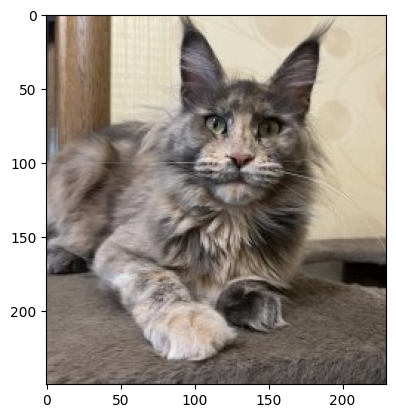

In [14]:
test_lzw(cat)

### Дуже слабо ефективне стиснення зображення

Практичний результат:
Розмір зображенння: Ширина - 1280 , Висота - 795
Кількість бітів на оригінальне зображення:  24422400 (2981.25 КБ)
Розмір списку з закодованими значеннями -  890262
Кількість бітів на закодоване зображенння (3 байт на символ) 21366288 (2608.189453125 КБ)
Різниця: 3056112
Коефіцієнт стиснення: 1.1430342977685222
Закодоване зображення займає 87.49 % оригінального зображення
--------------
Теоретичний результат, якщо на кожий символ давати мінімальну кількість бітів:
(Ідеал) Розмір зображення в бітах: 20806224
(Ідеал) Розмір закодованого зображення в бітах: 14634324
(Ідеал) Різниця: 6171900
(Ідеал) Коефіцієнт стиснення -  1.4217413800596461
(Ідеал) Закодоване зображення займає 70.34 % оригінального зображення
--------------
Чи декодоване зображення ідентичне до оригінального: True


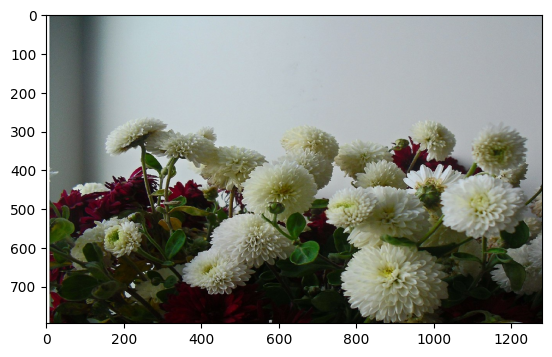

In [15]:
test_lzw(flowers)

### Слабо ефективне стиснення


Практичний результат:
Розмір зображенння: Ширина - 1920 , Висота - 1080
Кількість бітів на оригінальне зображення:  49766400 (6075.0 КБ)
Розмір списку з закодованими значеннями -  1471106
Кількість бітів на закодоване зображенння (3 байт на символ) 35306544 (4309.880859375 КБ)
Різниця: 14459856
Коефіцієнт стиснення: 1.409551725028652
Закодоване зображення займає 70.94 % оригінального зображення
--------------
Теоретичний результат, якщо на кожий символ давати мінімальну кількість бітів:
(Ідеал) Розмір зображення в бітах: 47565139
(Ідеал) Розмір закодованого зображення в бітах: 25673441
(Ідеал) Різниця: 21891698
(Ідеал) Коефіцієнт стиснення -  1.8526982417354962
(Ідеал) Закодоване зображення займає 53.98 % оригінального зображення
--------------
Чи декодоване зображення ідентичне до оригінального: True


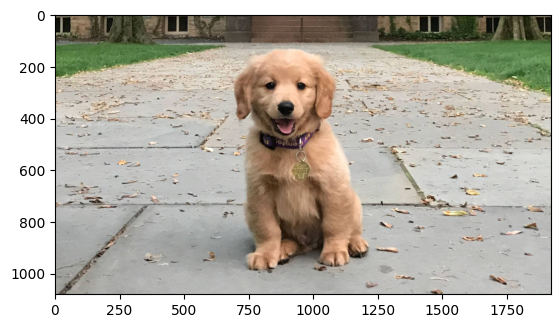

In [16]:
test_lzw(dog)

### Достатньо ефективне стиснення

Практичний результат:
Розмір зображенння: Ширина - 556 , Висота - 477
Кількість бітів на оригінальне зображення:  6365088 (776.98828125 КБ)
Розмір списку з закодованими значеннями -  141450
Кількість бітів на закодоване зображенння (3 байт на символ) 3394800 (414.404296875 КБ)
Різниця: 2970288
Коефіцієнт стиснення: 1.8749522799575822
Закодоване зображення займає 53.33 % оригінального зображення
--------------
Теоретичний результат, якщо на кожий символ давати мінімальну кількість бітів:
(Ідеал) Розмір зображення в бітах: 6336212
(Ідеал) Розмір закодованого зображення в бітах: 1898270
(Ідеал) Різниця: 4437942
(Ідеал) Коефіцієнт стиснення -  3.337887655602206
(Ідеал) Закодоване зображення займає 29.96 % оригінального зображення
--------------
Чи декодоване зображення ідентичне до оригінального: True


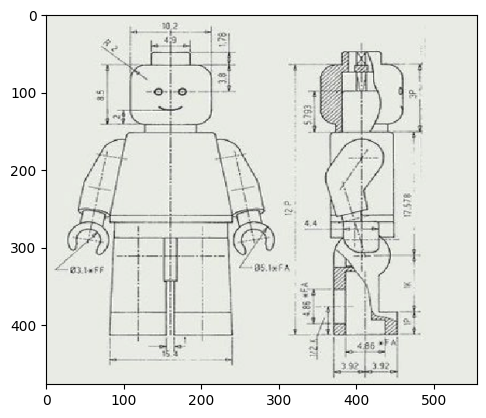

In [17]:
test_lzw(technical_drawing)

### Дуже ефективне стиснення

Практичний результат:
Розмір зображенння: Ширина - 1079 , Висота - 783
Кількість бітів на оригінальне зображення:  20276568 (2475.1669921875 КБ)
Розмір списку з закодованими значеннями -  82039
Кількість бітів на закодоване зображенння (3 байт на символ) 1968936 (240.3486328125 КБ)
Різниця: 18307632
Коефіцієнт стиснення: 10.298236204731896
Закодоване зображення займає 9.71 % оригінального зображення
--------------
Теоретичний результат, якщо на кожий символ давати мінімальну кількість бітів:
(Ідеал) Розмір зображення в бітах: 19631176
(Ідеал) Розмір закодованого зображення в бітах: 1144823
(Ідеал) Різниця: 18486353
(Ідеал) Коефіцієнт стиснення -  17.14778267033419
(Ідеал) Закодоване зображення займає 5.83 % оригінального зображення
--------------
Чи декодоване зображення ідентичне до оригінального: True


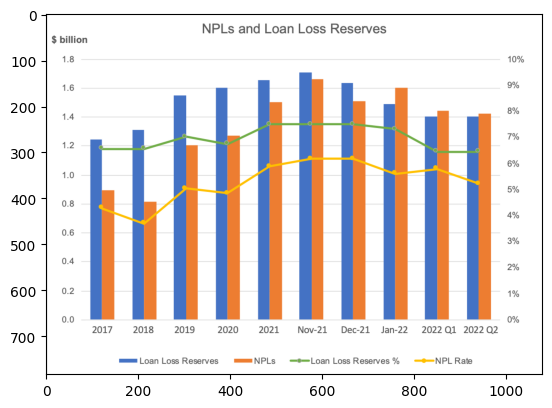

In [18]:
test_lzw(chart)

## Стиснення зображення в бінарний файл

In [19]:
technical_drawing = cv2.imread('images/technical-drawing.png')
technical_drawing = cv2.cvtColor(technical_drawing, cv2.COLOR_BGR2RGB)

chart = cv2.imread('images/charts.png')
chart = cv2.cvtColor(chart, cv2.COLOR_BGR2RGB)

In [20]:
def save_image_bin(img, filename: str):
    img_bytes = img.tobytes()
    with open(filename, 'wb') as binary_file:
        binary_file.write(img_bytes)

In [21]:
def read_image_bin(filename, shape, dtype=np.uint8):
    with open(filename, 'rb') as binary_file:
        img_bytes = binary_file.read()
    img_array = np.frombuffer(img_bytes, dtype=dtype).reshape(shape)
    return img_array


In [22]:
def save_lzw_encoded_to_file(encoded_data, filename):
    with open(filename, 'wb') as binary_file:
        for value in encoded_data:
            binary_file.write(struct.pack('>I', value)[1:4])


In [23]:
def read_lzw_encoded_from_file(filename):
    encoded_data = []
    with open(filename, 'rb') as binary_file:
        while True:
            bytes_read = binary_file.read(3)
            if not bytes_read:
                break
            value = struct.unpack('>I', b'\x00' + bytes_read)[0]
            encoded_data.append(value)
    return encoded_data


In [24]:
def test_binary_files(img, name:str):
    img_filename = name+"_image.bin"
    lzw_filename = name+"_lzw.bin"
    save_image_bin(img, img_filename)
    image_from_file = read_image_bin(img_filename, img.shape)
    print("Чи ідентичні оригінальне зображенння та прочитане з бінарного файла", np.array_equal(image_from_file, img))
    lzw_encoded = encode_rgb_image(img)
    save_lzw_encoded_to_file(lzw_encoded, lzw_filename)
    lzw_from_file = read_lzw_encoded_from_file(lzw_filename)
    print("Чи ідентичні закодоване зображенння та прочитане закодоване зображення з бінарного файла", np.array_equal(lzw_from_file, lzw_encoded))
    print("-------------")
    img_bin_size = os.path.getsize(img_filename)
    lzw_bin_size = os.path.getsize(lzw_filename)
    print("Розмір оригінального зображення:", img_bin_size)
    print("Розмір закодованого зображення:", lzw_bin_size)
    print("Різниця розмірів файлів:", (img_bin_size - lzw_bin_size)/1024, "КБ")


In [25]:
test_binary_files(chart, "chart")

Чи ідентичні оригінальне зображенння та прочитане з бінарного файла True
Чи ідентичні закодоване зображенння та прочитане закодоване зображення з бінарного файла True
-------------
Розмір оригінального зображення: 2534571
Розмір закодованого зображення: 246117
Різниця розмірів файлів: 2234.818359375 КБ


In [26]:
test_binary_files(technical_drawing, "technical_drawing")

Чи ідентичні оригінальне зображенння та прочитане з бінарного файла True
Чи ідентичні закодоване зображенння та прочитане закодоване зображення з бінарного файла True
-------------
Розмір оригінального зображення: 795636
Розмір закодованого зображення: 424350
Різниця розмірів файлів: 362.583984375 КБ


# Висновок

1. LZW відносно простий у реалізації порівняно з іншими алгоритмами стиснення, такими як Хаффман або Deflate. Це робить його привабливим вибором для багатьох програм, де потрібна простота та надійність.<br>
2. LZW є алгоритмом стиснення без втрат, що означає, що оригінальні дані можуть бути повністю відновлені зі стисненого файлу без втрати якості.
3. LZW добре працює з зображеннями, що містять багато повторюваних послідовностей пікселів, наприклад, з великими однотонними областями (графіки, діаграми, логотипи). Це дозволяє значно зменшити розмір файлу без втрат якості. 
4. LZW не завжди видає гарні результати при стисненні зображень, що містять багато деталей або високий рівень шуму. Це пов'язано з тим, що LZW грунтується на роботі з повторюваними послідовностями. Складні зображення, де мало повторюваних структур, можуть не бути ефективно стиснені цим алгоритмом.


